# Land ice SMB model comparison
This notebook compares the downscaled output of surface mass balance (SMB) over the Greenland ice sheet (GrIS) to the regional model MAR. In what follows, we interchangeably call the MAR data "observation".
\
Note1: the MAR data are processed as a climatology spanning 1960-1999.\
Note2: the MAR data are available at a uniform resolution of 1km using the same projection as the CISM grid. This notebook requires the interpolation of the MAR data on the CISM grid. The interpolation is done in this notebook (for now) to allow for the eventuality of the CISM grid or the MAR grid to change in the future. \
creation: 05-26-24 \
contact: Gunter Leguy (gunterl@ucar.edu)

In [1]:
# Import packages
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mcm
from scipy.interpolate import RegularGridInterpolator
import xarray as xr

import utils

# to display figures in notebook after executing the code.
%matplotlib inline

## Parameter configuration

Some parameters are set in CUPiD's `config.yml` file,
others are derived from these parameters.

In [2]:
# Parameter Defaults

CESM_output_dir = ""
case_name = ""  # case name
climo_nyears = 0  # number of years to compute the climatology for main case
end_date = ""

base_case_output_dir = None
base_case_name = None
base_end_date = None
base_climo_nyears = 0  # number of years to compute the climatology for base case

obs_path = ""  # directory containing observed dataset
obs_name = ""  # file name for observed dataset

In [3]:
# Parameters
case_name = "b.e30_beta02.BLT1850.ne30_t232.104"
base_case_name = "b.e23_alpha17f.BLT1850.ne30_t232.092"
CESM_output_dir = "/glade/campaign/cesm/development/cross-wg/diagnostic_framework/CESM_output_for_testing"
start_date = "0001-01-01"
end_date = "0101-01-01"
base_start_date = "0001-01-01"
base_end_date = "0101-01-01"
lc_kwargs = {"threads_per_worker": 1}
serial = False
obs_path = "/glade/campaign/cesm/development/cross-wg/diagnostic_framework/CUPiD_obs_data/glc/analysis_datasets/multi_grid/annual_avg/SMB_data"
obs_name = "GrIS_MARv3.12_climo_1960_1999.nc"
climo_nyears = 40
subset_kwargs = {}
product = "/glade/work/samrabin/cupid_crops/examples/key_metrics/computed_notebooks//glc/Greenland_SMB_visual_compare_obs.ipynb"


In [4]:
# Want some base case parameter defaults to equal control case values
if base_case_name is not None:
    if base_case_output_dir is None:
        base_case_output_dir = CESM_output_dir

    if base_end_date is None:
        base_end_date = end_date

    if base_climo_nyears == 0:
        base_climo_nyears = climo_nyears

In [5]:
last_year = int(end_date.split("-")[0])

case_init_file = os.path.join(
    obs_path, "cism.gris.initial_hist.0001-01-01-00000.nc"
)  # name of glc file output

case_path = os.path.join(
    CESM_output_dir, case_name, "cpl", "hist"
)  # path to glc output
case_file = os.path.join(
    case_path, f"{case_name}.cpl.hx.1yr2glc.{last_year:04d}-01-01-00000.nc"
)  # name of glc file output
obs_file = os.path.join(obs_path, obs_name)  # name of observed dataset file

if base_case_name is not None:
    base_last_year = int(base_end_date.split("-")[0])
    base_case_path = os.path.join(
        base_case_output_dir, base_case_name, "cpl", "hist"
    )  # path to cpl output
    base_file = os.path.join(
        base_case_path,
        f"{base_case_name}.cpl.hx.1yr2glc.{base_last_year:04d}-01-01-00000.nc",
    )  # name of last cpl simulation output

## Set up grid

Read in the grid data, compute resolution and other grid-specific parameters

In [6]:
## Get grid from initial_hist stream
thk_init_da = xr.open_dataset(case_init_file).isel(time=0)["thk"]
mask = thk_init_da.data[:, :] == 0

# Shape of array is (ny, nx)
grid_dims = thk_init_da.shape

In [7]:
# Constants
res = np.abs(
    thk_init_da["x1"].data[1] - thk_init_da["x1"].data[0]
)  # CISM output resolution

rhow = 1000  # water density kg/m3
kg_to_Gt = 1e-12  # Converting kg to Gt
mm_to_Gt = rhow * 1e-3 * res**2 * kg_to_Gt  # converting mm/yr to Gt/yr

In [8]:
params = {
    "grid_dims": grid_dims,
    "mm_to_Gt": mm_to_Gt,
    "mask": mask,
}

## Make datasets

Read in observations and CESM output.
Also do necessary computations
(global mean for time series, temporal mean for climatology).

In [9]:
# creating the SMB climatology for new case
smb_case = utils.read_cesm_smb(case_path, case_name, last_year, climo_nyears, params)
smb_case_climo = smb_case.mean("time")

# creating the SMB climatology for base_case
if base_case_name:
    smb_base_case = utils.read_cesm_smb(
        base_case_path, base_case_name, base_last_year, base_climo_nyears, params
    )
    smb_base_climo = smb_base_case.mean("time")

number of years used in climatology =  40


number of years used in climatology =  40


In [10]:
# Interpolating the observed data onto the CISM grid
smb_obs_da = xr.open_dataset(obs_file).isel(time=0)["SMB"]

# Defining the interpolation functions
myInterpFunction_smb_obs = RegularGridInterpolator(
    (smb_obs_da["x"].data, smb_obs_da["y"].data),
    smb_obs_da.data.transpose(),
    method="linear",
    bounds_error=False,
    fill_value=None,
)

# Initializing the glacier ID variable
smb_obs_climo = xr.DataArray(np.zeros(grid_dims), dims=["glc1Exp_ny", "glc1Exp_nx"])

# Performing the interpolation
for j in range(grid_dims[0]):
    point_y = np.zeros(grid_dims[1])
    point_y[:] = thk_init_da["y1"].data[j]
    pts = (thk_init_da["x1"].data[:], point_y[:])
    smb_obs_climo.data[j, :] = myInterpFunction_smb_obs(pts)

# Filtering out fill values
smb_obs_climo.data = np.where(
    np.logical_or(mask, smb_obs_climo > 1e20), 0, smb_obs_climo
)

In [11]:
# Integrated SMB time series
first_year = last_year - len(smb_case["time"]) + 1
avg_smb_case_climo = smb_case.sum(["glc1Exp_ny", "glc1Exp_nx"]) * params["mm_to_Gt"]

if base_case_name:
    base_first_year = base_last_year - len(smb_base_case["time"]) + 1
    avg_smb_base_case_climo = (
        smb_base_case.sum(["glc1Exp_ny", "glc1Exp_nx"]) * params["mm_to_Gt"]
    )

## Generate plots

Map comparing CESM to observation,
possibly map comparing CESM to older case,
and time series of spatial mean SMB.

/glade/derecho/scratch/samrabin/tmp/ipykernel_9051/1639303292.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  my_cmap = mcm.get_cmap("Spectral")
/glade/derecho/scratch/samrabin/tmp/ipykernel_9051/1639303292.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  my_cmap_diff = mcm.get_cmap("bwr_r")


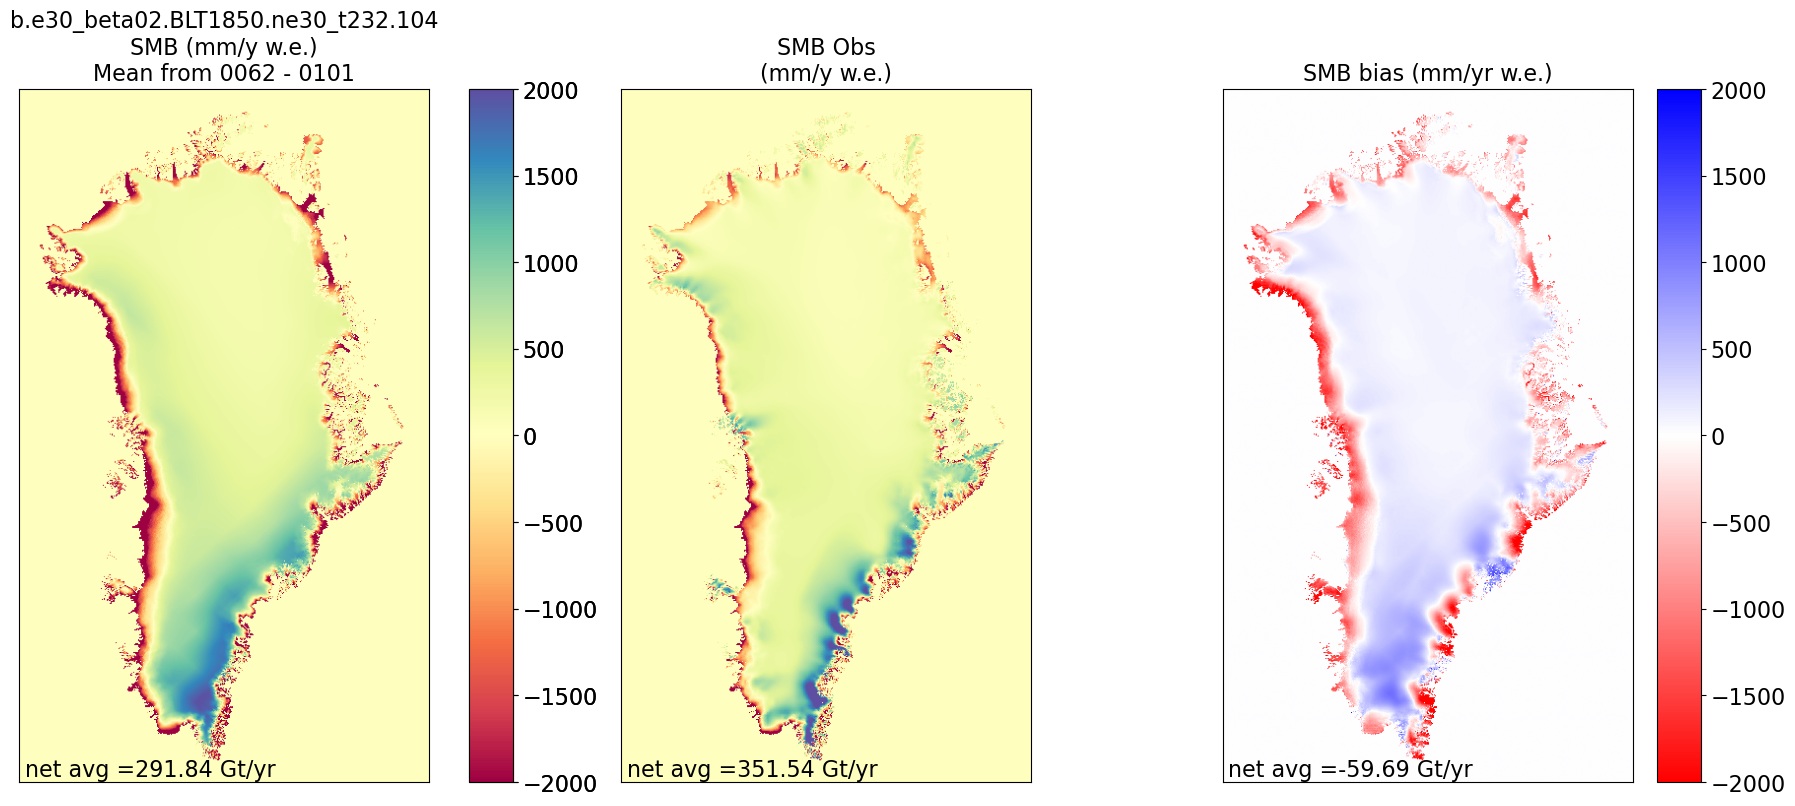

In [12]:
# Comparing SMB new run vs obs

# Colormap choice
my_cmap = mcm.get_cmap("Spectral")
my_cmap_diff = mcm.get_cmap("bwr_r")


# Colorbar bounds
vmin = -2000
vmax = 2000

# Figure
fig, ax = plt.subplots(1, 3, sharey=True, figsize=[22, 9])

## Left panel
utils.plot_contour(
    smb_case_climo,
    fig,
    ax[0],
    0.35,
    f"{case_name}\nSMB (mm/y w.e.)\nMean from {first_year:04d} - {last_year:04d}",
    vmin,
    vmax,
    my_cmap,
    mm_to_Gt,
)

## Center panel
utils.plot_contour(
    smb_obs_climo,
    fig,
    ax[1],
    0.35,
    "SMB Obs\n(mm/y w.e.)",
    vmin,
    vmax,
    my_cmap,
    mm_to_Gt,
)

## Right panel
utils.plot_contour(
    smb_case_climo - smb_obs_climo,
    fig,
    ax[2],
    0.89,
    "SMB bias (mm/yr w.e.)",
    vmin,
    vmax,
    my_cmap_diff,
    mm_to_Gt,
)

/glade/derecho/scratch/samrabin/tmp/ipykernel_9051/2450413827.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  my_cmap = mcm.get_cmap("Spectral")
/glade/derecho/scratch/samrabin/tmp/ipykernel_9051/2450413827.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  my_cmap_diff = mcm.get_cmap("bwr_r")


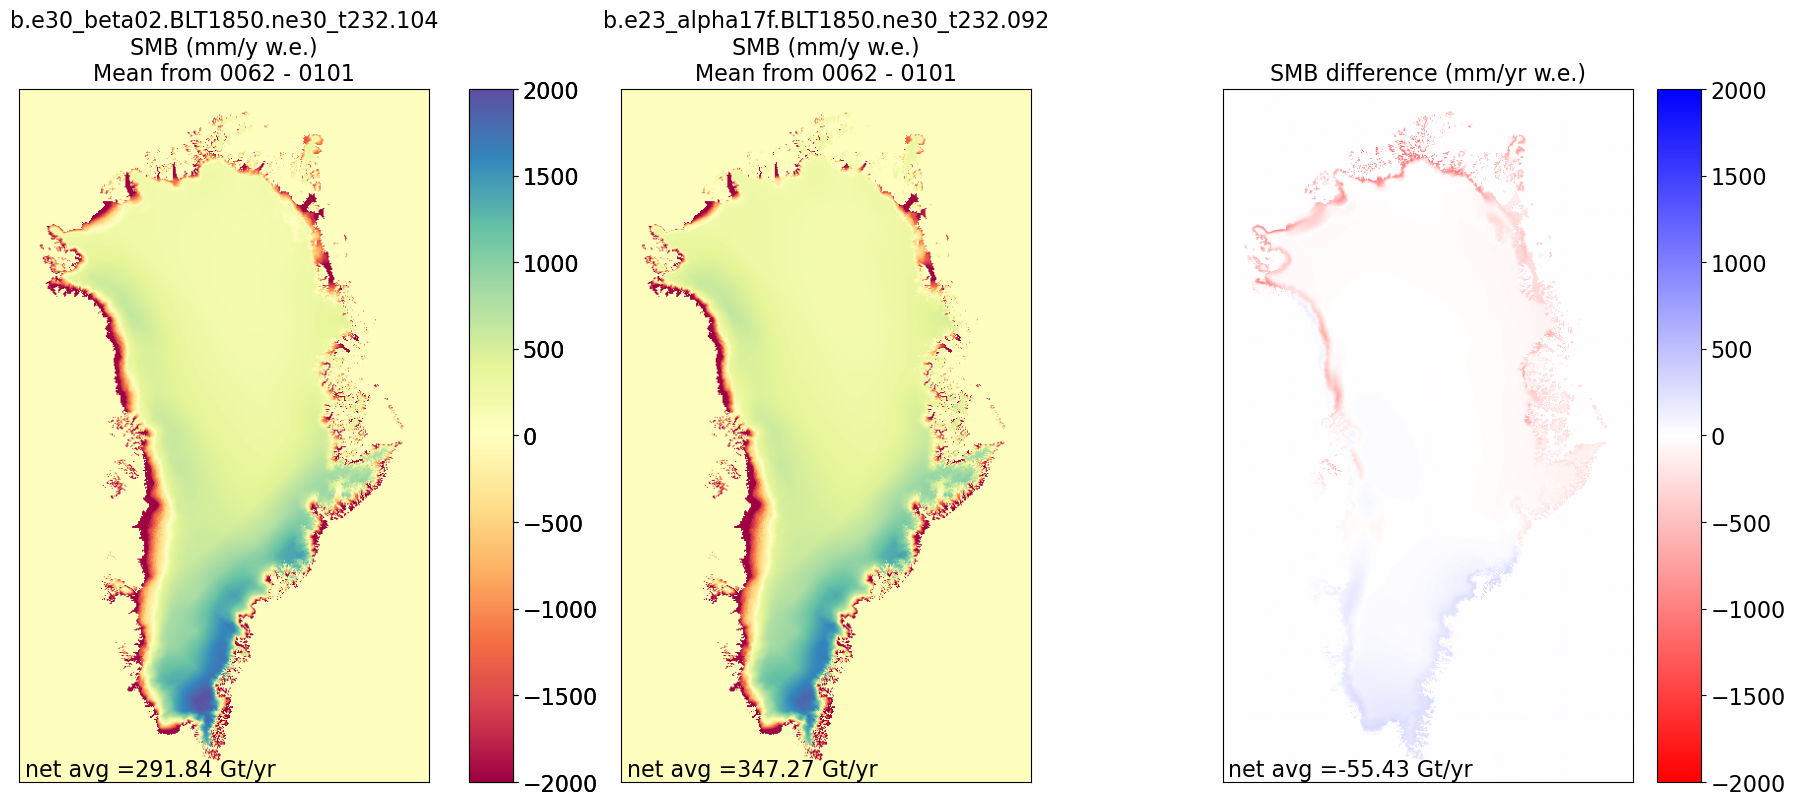

In [13]:
# Comparing SMB new run vs base case
if base_case_name:
    # Colormap choice
    my_cmap = mcm.get_cmap("Spectral")
    my_cmap_diff = mcm.get_cmap("bwr_r")

    # Colorbar bounds
    vmin = -2000
    vmax = 2000

    # Figure
    fig, ax = plt.subplots(1, 3, sharey=True, figsize=[22, 9])

    ## Left panel
    utils.plot_contour(
        smb_case_climo,
        fig,
        ax[0],
        0.35,
        f"{case_name}\nSMB (mm/y w.e.)\nMean from {first_year:04d} - {last_year:04d}",
        vmin,
        vmax,
        my_cmap,
        mm_to_Gt,
    )

    ## Center panel
    utils.plot_contour(
        smb_base_climo,
        fig,
        ax[1],
        0.35,
        f"{base_case_name}\nSMB (mm/y w.e.)\nMean from {base_first_year:04d} - {base_last_year:04d}",
        vmin,
        vmax,
        my_cmap,
        mm_to_Gt,
    )

    ## Right panel
    utils.plot_contour(
        smb_case_climo - smb_base_climo,
        fig,
        ax[2],
        0.89,
        "SMB difference (mm/yr w.e.)",
        vmin,
        vmax,
        my_cmap_diff,
        mm_to_Gt,
    )

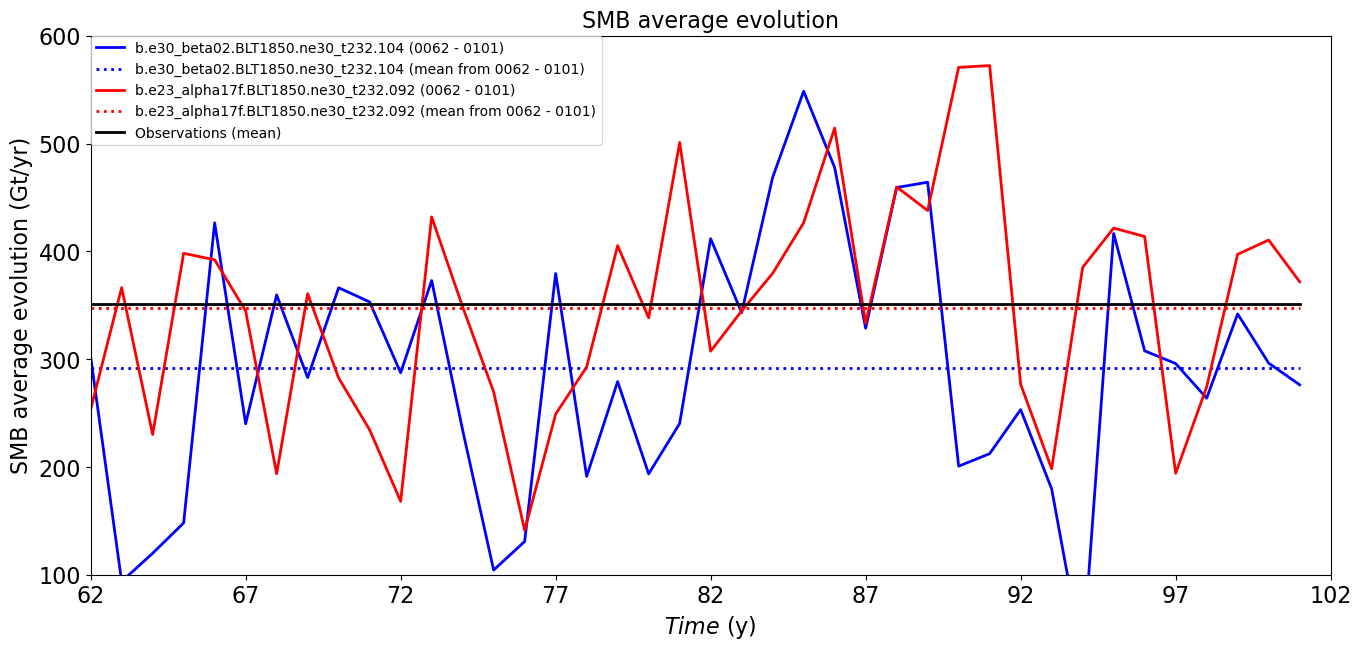

In [14]:
# Plotting the SMB spatially averaged time series

# TODO: include base case, base case climo (horizontal line), new case, new case climo, and obs climo
# Note: base case is 10 years of historical, new case is PI.
#       what comparisons make sense when base case is HIST and new case is 1850?


time = np.arange(first_year, last_year + 1)
full_time = time
if base_case_name:
    base_time = (
        np.arange(base_first_year, base_last_year + 1) + first_year - base_first_year
    )
    base_nt = len(base_time)
    full_time = np.arange(time[0], max(time[-1], base_time[-1]) + 1)
nt = len(time)

avg_smb_obs_timeseries = np.zeros(len(full_time))
avg_smb_case_timeseries = np.zeros(nt)
if base_case_name:
    avg_smb_base_timeseries = np.zeros(base_nt)

avg_smb_obs_timeseries[:] = np.round(smb_obs_climo.sum() * mm_to_Gt, 2)
avg_smb_case_timeseries[:] = np.round(smb_case_climo.sum() * mm_to_Gt, 2)
if base_case_name:
    avg_smb_base_timeseries[:] = np.round(smb_base_climo.sum() * mm_to_Gt, 2)


x_ticks = np.arange(full_time[0], full_time[-1] + 2, 5)
tickx = x_ticks

ymin = 100
ymax = 600
y_step = 50
y_ticks = np.arange(ymin, ymax + y_step, y_step)


plt.figure(figsize=(16, 7))

# Plotting annual / spatial means
plt.subplot(111)
utils.plot_line(
    avg_smb_case_climo,
    time,
    line="-",
    color="blue",
    label=f"{case_name} ({first_year:04d} - {last_year:04d})",
    linewidth=2,
)
utils.plot_line(
    avg_smb_case_timeseries[:],
    time,
    line=":",
    color="blue",
    label=f"{case_name} (mean from {first_year:04d} - {last_year:04d})",
    linewidth=2,
)
if base_case_name:
    utils.plot_line(
        avg_smb_base_case_climo,
        base_time,
        line="-",
        color="red",
        label=f"{base_case_name} ({base_first_year:04d} - {base_last_year:04d})",
        linewidth=2,
    )
    utils.plot_line(
        avg_smb_base_timeseries[:],
        base_time,
        line=":",
        color="red",
        label=f"{base_case_name} (mean from {base_first_year:04d} - {base_last_year:04d})",
        linewidth=2,
    )
utils.plot_line(
    avg_smb_obs_timeseries[:],
    full_time,
    line="-",
    color="black",
    label="Observations (mean)",
    linewidth=2,
)

sizefont = 16
plt.xlim([first_year, last_year])
plt.xticks(x_ticks, tickx, fontsize=sizefont)
plt.xlabel(r"$Time$ (y)", fontsize=sizefont)
plt.ylabel("SMB average evolution (Gt/yr)", multialignment="center", fontsize=sizefont)
plt.ylim([ymin, ymax])
plt.yticks(fontsize=sizefont)
plt.legend(loc="upper left", ncol=1, frameon=True, borderaxespad=0)

plt.title("SMB average evolution", fontsize=sizefont);